<a href="https://colab.research.google.com/github/Alimv81/emotion_detection_FER2012/blob/main/emotion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import zipfile
import numpy as np
import pandas as pd
from keras import regularizers
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
gpu = tf.config.list_physical_devices('GPU')
if gpu:
  tf.config.experimental.set_memory_growth(gpu[0], True)

In [3]:
url = "https://huggingface.co/spaces/mxz/emtion/resolve/c697775e0adc35a9cec32bd4d3484b5f5a263748/fer2013.csv"
df = pd.read_csv(url)

In [4]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
df['Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [6]:
df_train = df[df['Usage']=='Training'].copy()
df_test = df[df['Usage']=='PublicTest'].copy()
df_valid = df[df['Usage']=='PrivateTest'].copy()

In [7]:
def split_data(data):
  data['pixels'] = data['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
  images = np.array(data['pixels'].tolist(), dtype='float32').reshape(-1, 48, 48, 1) / 255.0
  images = np.repeat(images, 3, axis=-1) # to make the channels of the image into 3
  labels = data['emotion'].to_numpy()

  return images, labels

In [8]:
train_data, train_labels = split_data(df_train)
test_data, test_labels = split_data(df_test)
validation_data, validation_labels = split_data(df_valid)

In [9]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

In [10]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, SpatialDropout2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization


model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(48, 48, 3)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(SpatialDropout2D(0.25))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(SpatialDropout2D(0.25))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(SpatialDropout2D(0.25))

model.add(GlobalAveragePooling2D())

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))


In [26]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss)

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 46, 46, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                        

In [29]:
model.fit(train_data, train_labels, epochs=25, batch_size=64,
                    validation_data=(validation_data, validation_labels))

Epoch 1/10
449/449 [==============================] - 25s 44ms/step - loss: 1.0675 - val_loss: 0.9916
Epoch 2/10
449/449 [==============================] - 19s 43ms/step - loss: 1.0095 - val_loss: 0.9923
Epoch 3/10
449/449 [==============================] - 20s 44ms/step - loss: 0.9611 - val_loss: 0.9826
Epoch 4/10
449/449 [==============================] - 19s 43ms/step - loss: 0.9161 - val_loss: 0.9566
Epoch 5/10
449/449 [==============================] - 19s 43ms/step - loss: 0.8703 - val_loss: 0.9388
Epoch 6/10
449/449 [==============================] - 21s 46ms/step - loss: 0.8249 - val_loss: 1.0221
Epoch 7/10
449/449 [==============================] - 20s 44ms/step - loss: 0.7825 - val_loss: 0.9410
Epoch 8/10
449/449 [==============================] - 19s 43ms/step - loss: 0.7392 - val_loss: 0.9575
Epoch 9/10
449/449 [==============================] - 19s 43ms/step - loss: 0.6941 - val_loss: 0.9975
Epoch 10/10
449/449 [==============================] - 19s 42ms/step - loss: 0.649

In [42]:
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [43]:
predy = model.predict(test_data)

113/113 [==============================] - 1s 6ms/step


In [44]:
predy[0], np.argmax(predy[0])

(array([0.3724775 , 0.0069901 , 0.22279394, 0.00275234, 0.23914982,
        0.0006073 , 0.15522903], dtype=float32),
 0)

In [45]:
from sklearn.metrics import accuracy_score

print(accuracy_score(test_labels, np.argmax(predy, axis=1)))

0.6425188074672611


In [46]:
idx = [9, 184, 1348, 2834]
image_batch = test_data[idx]
label_batch = test_labels[idx]
label_batch_pred = np.argmax(predy[idx], axis=1)

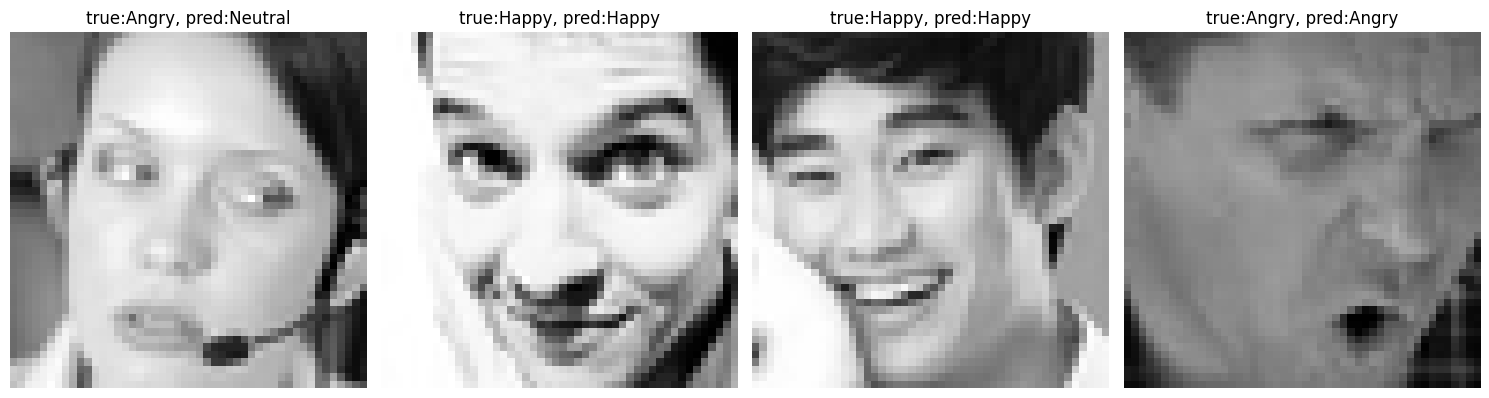

In [47]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

for i, ax in enumerate(axes):
    image = image_batch[i]
    ax.imshow(image)
    ax.set_title(f'true:{emotion_map[label_batch[i]]}, pred:{emotion_map[label_batch_pred[i]]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [48]:
path = '/content/drive/MyDrive/Colab Notebooks/Datasets/File.zip'

In [49]:
with zipfile.ZipFile(path, 'r') as zip_ref:
  zip_ref.extractall('extracted/')

In [50]:
images = []

files_names = os.listdir('extracted/')
for file_name in files_names:
  image = cv2.imread(os.path.join('extracted', file_name), cv2.IMREAD_COLOR)
  image = cv2.resize(image, (48, 48))
  image = image.astype('float32') / 255.0
  # image = np.expand_dims(image, axis=-1)
  images.append(image)

In [51]:
images = np.array(images)
y_hat = np.argmax(model.predict(images), axis=1)

1/1 [==============================] - 0s 19ms/step


In [52]:
images.shape

(11, 48, 48, 3)

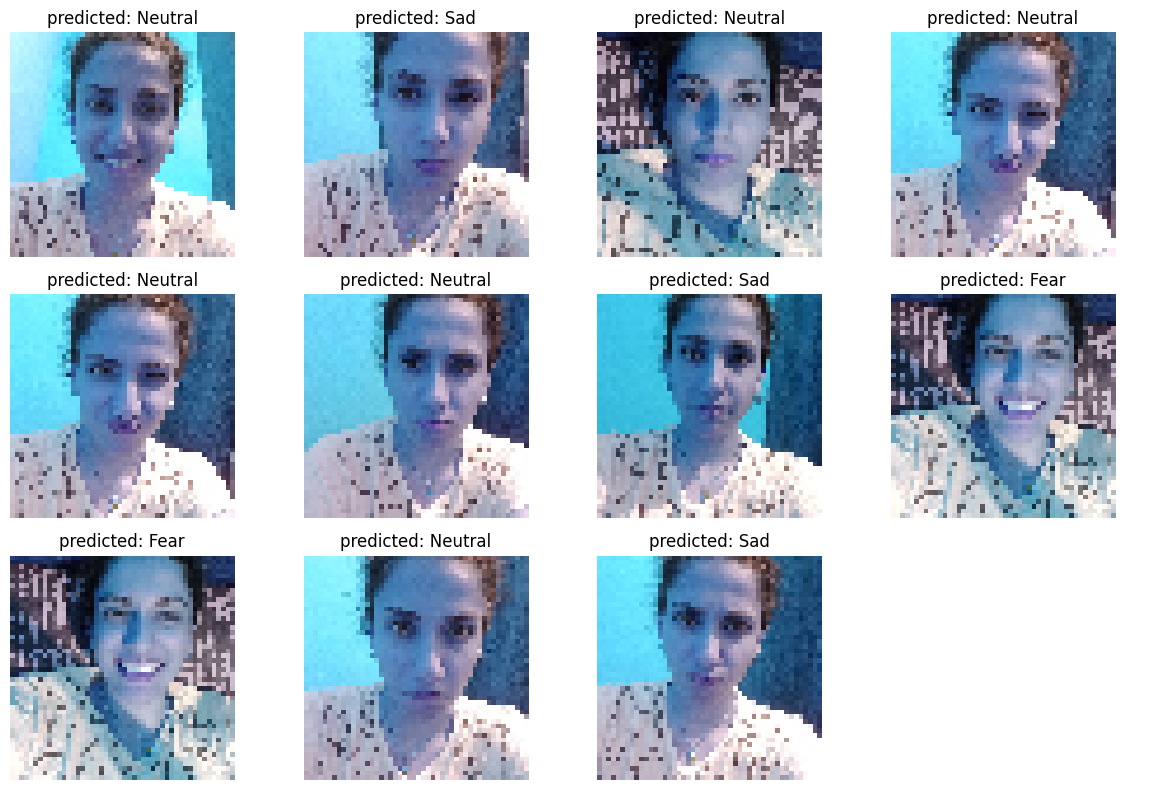

In [53]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))

for i in range(3):
  for j in range(4):
    ax = axes[i][j]
    if i!=2 or j!=3:
      ax.imshow(images[i*3 + j])
      ax.set_title(f'predicted: {emotion_map[y_hat[i*3 + j]]}')
    ax.axis('off')

plt.tight_layout()
plt.show()